# ISLR Chapter 7 - End of Chapter Applied exercises code portion solutions¶

Exercises from: "An Introduction to Statistical Learning with Applications in R" (Springer, 2013) by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani

Data: http://faculty.marshall.usc.edu/gareth-james/ISL/data.html

Code Solutions by Arthur Avila

In [1]:
require(ISLR)
require(knitr)
require(MASS)
require(reshape2)
require(tidyverse)
require(parallel)
require(GGally)
require(splines)
require(broom)

Loading required package: ISLR
Loading required package: knitr
Loading required package: MASS
Loading required package: reshape2
Loading required package: tidyverse
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.1     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
✖ dplyr::select() masks MASS::select()
Loading required package: parallel
Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Attaching package: ‘GGally’

The following object is masked from ‘package:dplyr’:

    nasa

Loading required package: splines
Loading required package: broom


### 6. In this exercise, you will further analyze the `Wage` data set considered throughout this chapter.

#### (a) Perform polynomial regression to predict `wage` using `age` . Use cross-validation to select the optimal degree $d$ for the polynomial. What degree was chosen, and how does this compare to the results of hypothesis testing using ANOVA? Make a plot of the resulting polynomial fit to the data.

In [9]:
lm_poly_for_CV <- function(train, m){
  # predicts model for each polynomial of degree up to m on test sample, returns mse
  lm.pred <- sapply(1:m, function(p) {
    predict(lm(wage~poly(age, p, raw=T), data=Wage, subset = train), 
            Wage[!train,], type='response')})
  error <- apply(lm.pred, 2, function(pred) mean((Wage[!train,'wage']-pred)**2))
  return(error)
}

lm_CV <- function(k, rounds, m, model_for_cv, seed=NULL){
  if (!is.null(seed)) set.seed(seed)
  folds<-replicate(rounds,sample(rep(1:k, length=nrow(Wage)))) 
  cv.samples <- sapply(1:k, function(i) i==folds, simplify = "array")
  cl <- makeCluster(detectCores(), type = 'FORK')
  errors <- parApply(cl, cv.samples, -1, model_for_cv, m)
  stopCluster(cl)
  return(errors)
}
                       
lm_errors <- lm_CV(10,5,5, lm_poly_for_CV, 4644321)

In [3]:
str(lm_errors)

 num [1:5, 1:5, 1:10] 1647 1577 1575 1574 1573 ...


          Degree       Error.Mean Error.Mean.Stdev            Lower 
        3.000000      1614.429475         4.378588      1605.672299 
           Upper 
     1623.186651 


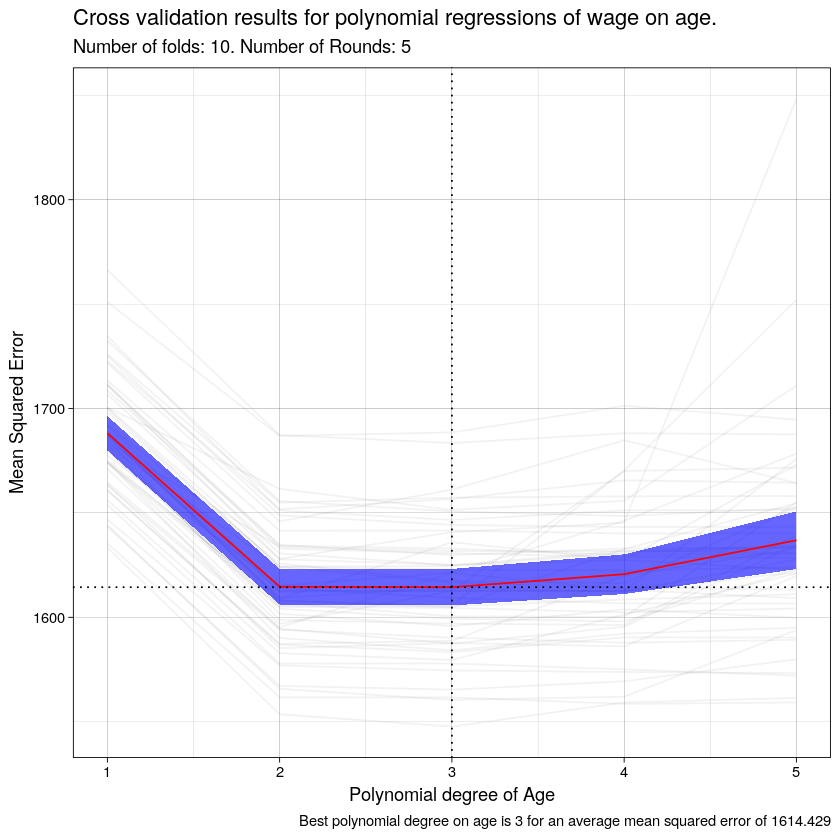

In [10]:
lmcvplots <- function(errors){
  m <- dim(errors)[1]
  k <- dim(errors)[3]
  rounds <- dim(errors)[2]
  errors_reshape <- array(errors, dim=c(dim(errors)[1],prod(dim(errors)[-1])))
  errors_df <- data.frame(errors_reshape)
  
  pows <- 1:m
  errors_df$degree = pows
  errors_melt <- melt(errors_df, 
                      value.name = "Error.Rate", 
                      variable.name = "CV.Round",
                      id.vars = 'degree')
  errors_melt <- errors_melt %>%
    group_by(degree) %>%
    mutate(Error.Mean = mean(Error.Rate),
           Error.Stdev = sd(Error.Rate)/sqrt(length(Error.Rate)),
           Lower = Error.Mean - 2*Error.Stdev,
           Upper = Error.Mean + 2*Error.Stdev) %>%
    ungroup(prior)
  
  error_means <- apply(errors_reshape,1,mean)
  error_stdev <- apply(errors_reshape,1,sd)/sqrt(prod(dim(errors)[-1]))
  besterror <- min(error_means)
  bestdegree <- pows[error_means == besterror]
  beststdev <- error_stdev[error_means == besterror]
  bestsummary <- c(Degree = bestdegree, Error.Mean = besterror, 
                   Error.Mean.Stdev = beststdev, 
                   Lower = besterror-2*beststdev,
                   Upper = besterror+2*beststdev)
  
  g<-ggplot(errors_melt, aes(degree, Error.Rate)) +
    geom_line(alpha=0.1, aes(group=CV.Round), colour = 'gray50') +
    #    stat_summary(fun.data ='mean_cl_normal', geom = 'ribbon', 
    geom_ribbon(aes(ymin=Lower, ymax=Upper),
                fill = 'blue', alpha = 0.6) + 
    geom_line(aes(y=Error.Mean), colour = 'red') +
    labs(x="Polynomial degree of Age",
         y="Mean Squared Error",
         title = "Cross validation results for polynomial regressions of wage on age.",
         subtitle = paste0("Number of folds: ", k, ". Number of Rounds: ", rounds),
         caption = paste0("Best polynomial degree on age is ",bestdegree,
                          " for an average mean squared error of ", 
                          round(besterror,3))) + 
    geom_hline(yintercept=besterror, lty = 3) +
    geom_vline(xintercept=bestdegree, lty = 3)
  return(list(table = bestsummary, plot = g))
}

poly_results <- lmcvplots(lm_errors) 

print(poly_results$table)

poly_results$plot+ theme_linedraw()

In [5]:
lm1 <- lm(wage~poly(age, 1, raw=T), data=Wage)
lm2 <- lm(wage~poly(age, 2, raw=T), data=Wage)
lm3 <- lm(wage~poly(age, 3, raw=T), data=Wage)
lm4 <- lm(wage~poly(age, 4, raw=T), data=Wage)
lm5 <- lm(wage~poly(age, 5, raw=T), data=Wage)

kable(anova(lm1, lm2, lm3, lm4, lm5))



| Res.Df|     RSS| Df|  Sum of Sq|           F|    Pr(>F)|
|------:|-------:|--:|----------:|-----------:|---------:|
|   2998| 5022216| NA|         NA|          NA|        NA|
|   2997| 4793430|  1| 228786.010| 143.5931074| 0.0000000|
|   2996| 4777674|  1|  15755.694|   9.8887559| 0.0016792|
|   2995| 4771604|  1|   6070.152|   3.8098134| 0.0510462|
|   2994| 4770322|  1|   1282.563|   0.8049758| 0.3696820|

Results match, but CV favor 2 degree polynomial for more rounds of replication.

          Degree       Error.Mean Error.Mean.Stdev            Lower 
       2.0000000     1613.2461617        0.8904188     1611.4653241 
           Upper 
    1615.0269993 


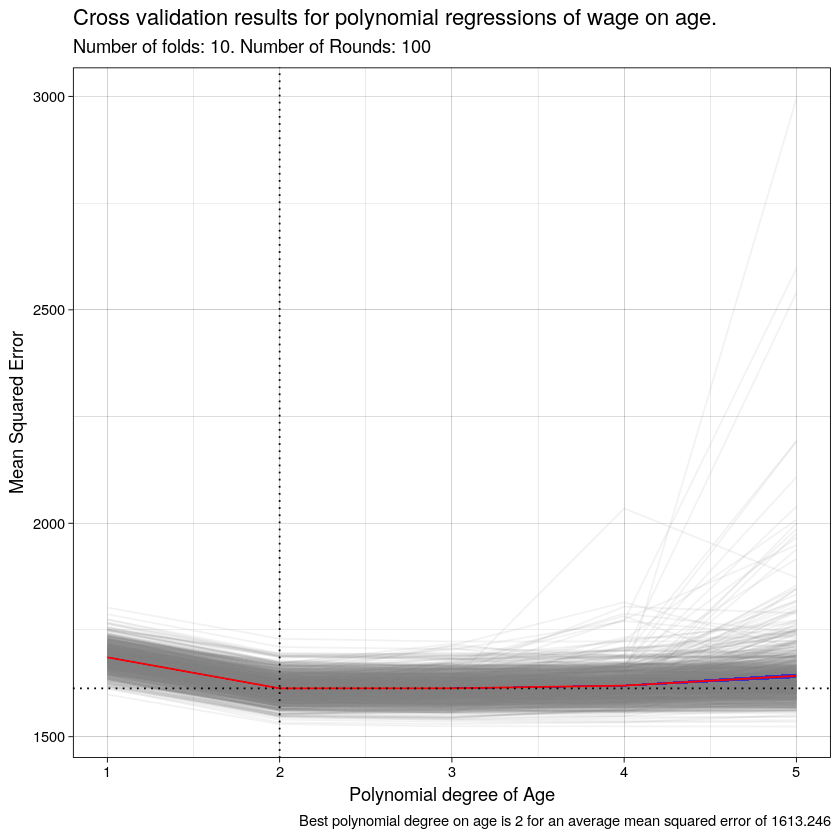

In [6]:
lm_errors2 <- lm_CV(10,100,5, lm_poly_for_CV, 4644321)
poly_results2 <- lmcvplots(lm_errors2) 

print(poly_results2$table)

poly_results2$plot+ theme_linedraw()

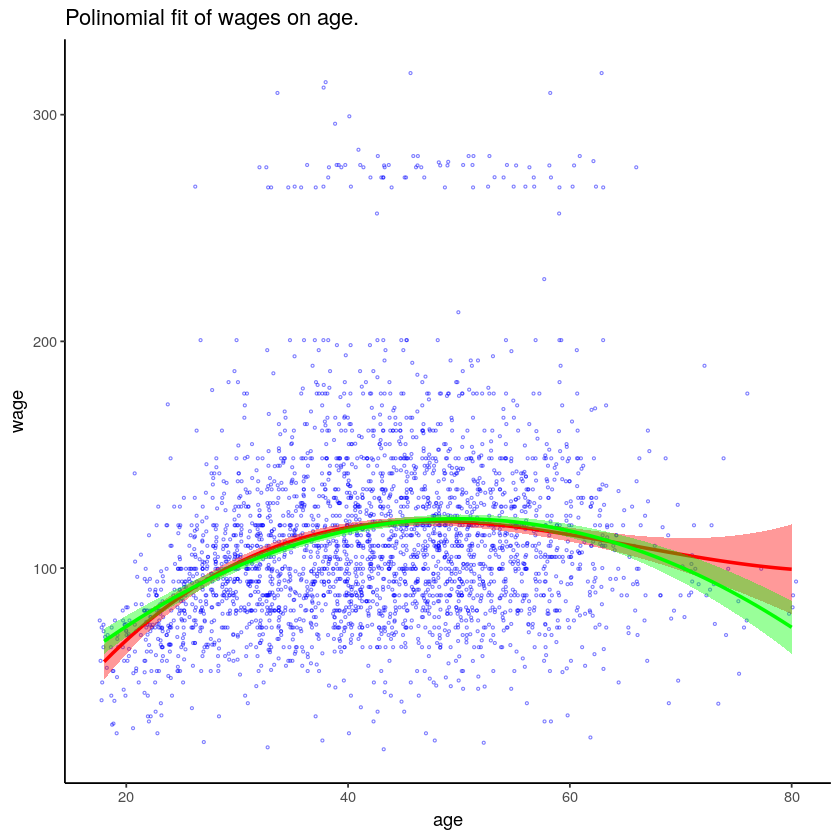

In [7]:
ggplot(Wage, aes(age, wage)) + 
  geom_jitter(pch=1, size=.5, alpha=0.5, col='blue') +
  geom_smooth(method = 'lm', formula = (y ~ poly(x, poly_results$table[1], raw=T)),
              col = "red", fill = 'red') +
  geom_smooth(method = 'lm', formula = (y ~ poly(x, poly_results2$table[1], raw=T)),
              col = "green", fill = 'green')+
  labs(title = "Polinomial fit of wages on age.")+
  theme_classic()

#### (b) Fit a step function to predict `wage` using `age`, and perform cross-validation to choose the optimal number of cuts. Make a plot of the fit obtained.

In [8]:
lm_cut_for_CV <- function(train, m){
  lm.pred <- sapply(2:m, function(p) {
    range <- range(Wage[train,'age'])
    cuts <- seq(range[1],range[2],length=p+1)
    cuts[c(1,p+1)]<-c(0,1000)   
    predict(lm(wage~cut(age, cuts), data=Wage, subset = train), 
            Wage[!train,], type='response')})
  error <- apply(lm.pred, 2, function(pred) mean((Wage[!train,'wage']-pred)**2))
  return(error)
}

lm_errors3 <- lm_CV(10,10,8, lm_cut_for_CV, 1)

            Cuts       Error.Mean Error.Mean.Stdev            Lower 
        6.000000      1643.070023         4.042806      1634.984410 
           Upper 
     1651.155636 


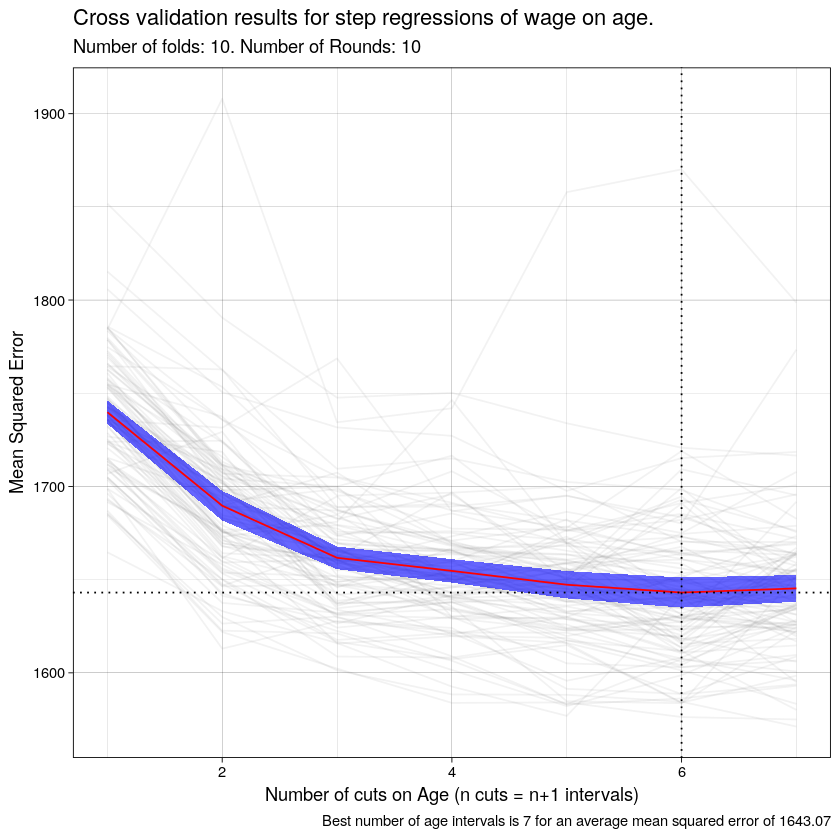

In [9]:
cut_results <- lmcvplots(lm_errors3)

names(cut_results$table)[1]<-"Cuts"
print(cut_results$table)

cut_results$plot+
labs(x="Number of cuts on Age (n cuts = n+1 intervals)",
         y="Mean Squared Error",
         title = "Cross validation results for step regressions of wage on age.",
         subtitle = paste0("Number of folds: ", dim(lm_errors3)[3], ". Number of Rounds: ", dim(lm_errors3)[2]),
         caption = paste0("Best number of age intervals is ",cut_results$table['Cuts']+1,
                          " for an average mean squared error of ", 
                          round(cut_results$table['Error.Mean'],3))) + theme_linedraw()

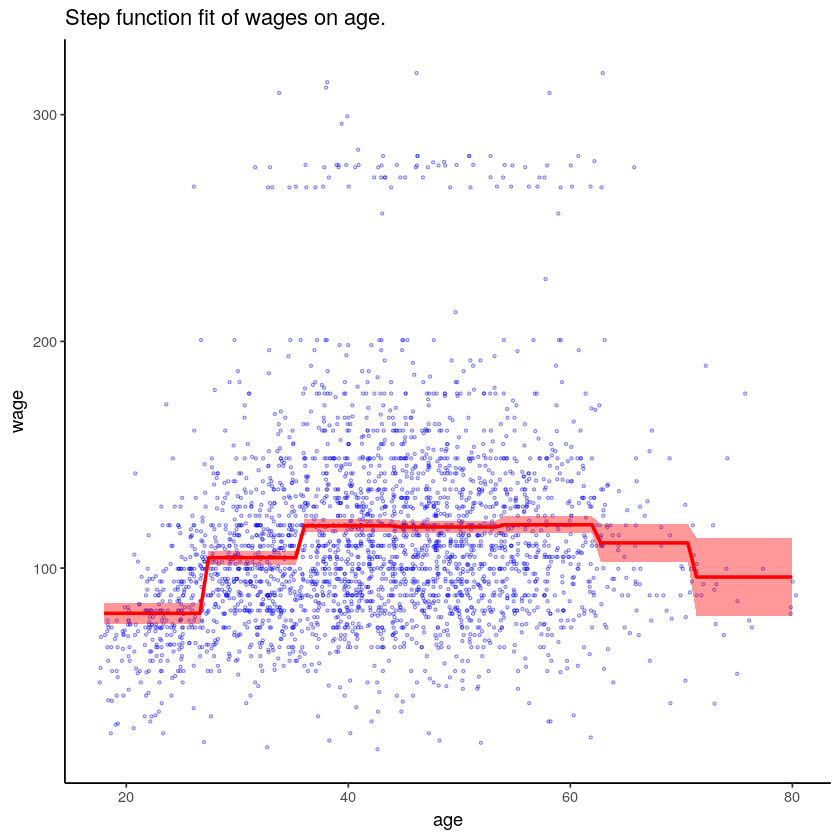

In [10]:
ggplot(Wage, aes(age, wage)) + 
  geom_jitter(pch=1, size=.5, alpha=0.5, col='blue') +
  geom_smooth(method = 'lm', formula = (y ~ cut(x, cut_results$table[1]+1, raw=T)),
              col = "red", fill = 'red') +
  labs(title = "Step function fit of wages on age.")+
  theme_classic()

### 7. The `Wage` data set contains a number of other features not explored in this chapter, such as marital status (`maritl`), job class (`jobclass`), and others. Explore the relationships between some of these other predictors and `wage`, and use non-linear fitting techniques in order to fit flexible models to the data. Create plots of the results obtained, and write a summary of your findings.

In [11]:
glimpse(Wage)

Observations: 3,000
Variables: 11
$ year       <int> 2006, 2004, 2003, 2003, 2005, 2008, 2009, 2008, 2006, 2004…
$ age        <int> 18, 24, 45, 43, 50, 54, 44, 30, 41, 52, 45, 34, 35, 39, 54…
$ maritl     <fct> 1. Never Married, 1. Never Married, 2. Married, 2. Married…
$ race       <fct> 1. White, 1. White, 1. White, 3. Asian, 1. White, 1. White…
$ education  <fct> 1. < HS Grad, 4. College Grad, 3. Some College, 4. College…
$ region     <fct> 2. Middle Atlantic, 2. Middle Atlantic, 2. Middle Atlantic…
$ jobclass   <fct> 1. Industrial, 2. Information, 1. Industrial, 2. Informati…
$ health     <fct> 1. <=Good, 2. >=Very Good, 1. <=Good, 2. >=Very Good, 1. <…
$ health_ins <fct> 2. No, 2. No, 1. Yes, 1. Yes, 1. Yes, 1. Yes, 1. Yes, 1. Y…
$ logwage    <dbl> 4.318063, 4.255273, 4.875061, 5.041393, 4.318063, 4.845098…
$ wage       <dbl> 75.04315, 70.47602, 130.98218, 154.68529, 75.04315, 127.11…


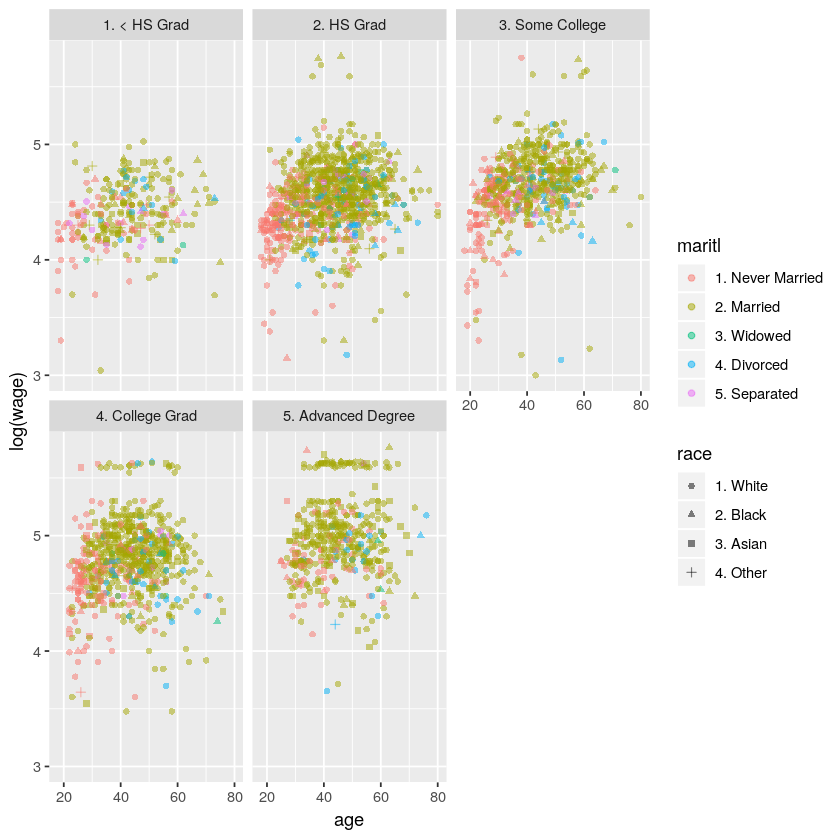

In [12]:
ggplot(Wage, aes(age, log(wage), color = maritl, pch=race)) + 
  geom_point(alpha=0.5) +
  facet_wrap(~education)

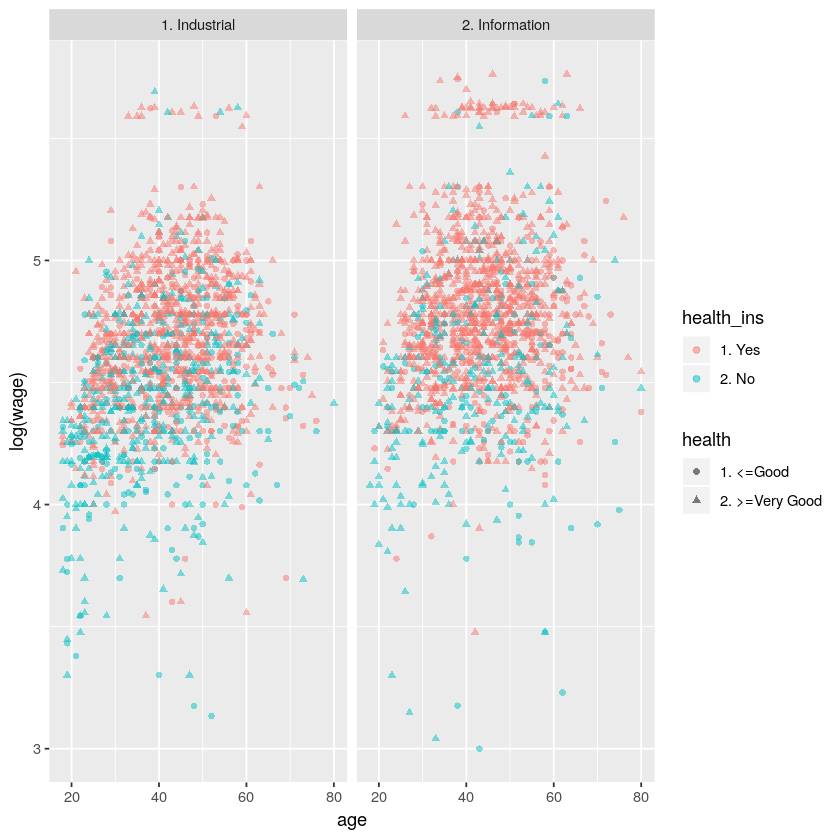

In [13]:
ggplot(Wage, aes(age, log(wage), color = health_ins, pch=health)) + 
  geom_point(alpha=0.5) +
  facet_wrap(~jobclass)

In [14]:
table(Wage$region)


       1. New England    2. Middle Atlantic 3. East North Central 
                    0                  3000                     0 
4. West North Central     5. South Atlantic 6. East South Central 
                    0                     0                     0 
7. West South Central           8. Mountain            9. Pacific 
                    0                     0                     0 

Loading required package: ggfortify


Single term deletions

Model:
log(wage) ~ year + age + health + health_ins + maritl + race + 
    jobclass + education
           Df Sum of Sq    RSS     AIC  F value    Pr(>F)    
<none>                  231.84 -7646.9                       
year        1     1.941 233.79 -7623.9  24.9738 6.147e-07 ***
age         1     1.928 233.77 -7624.0  24.8077 6.695e-07 ***
health      1     2.005 233.85 -7623.1  25.7967 4.027e-07 ***
health_ins  1    22.000 253.84 -7376.9 283.0559 < 2.2e-16 ***
maritl      4    12.301 244.15 -7499.8  39.5677 < 2.2e-16 ***
race        3     0.566 232.41 -7645.6   2.4271   0.06367 .  
jobclass    1     0.440 232.28 -7643.2   5.6564   0.01745 *  
education   4    42.980 274.82 -7144.7 138.2477 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Call:
lm(formula = log(wage) ~ year + age + health + health_ins + maritl + 
    race + jobclass + education, data = Wage)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.52379 -0.1

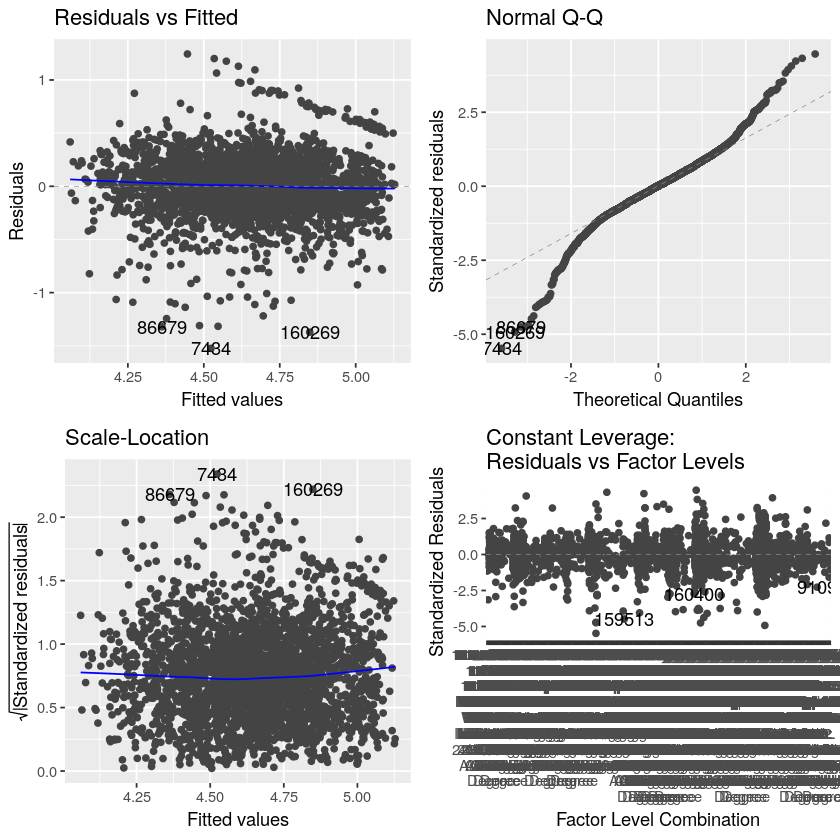

In [15]:
require(ggfortify)
lm_wage <- lm(log(wage)~year+age+health+health_ins+maritl+race+jobclass+education, data=Wage)
print(drop1(lm_wage, test="F"))
print(summary(lm_wage))
autoplot(lm_wage)

In [9]:
require(splines)
mdf = 10
n_fold = 10
#summary(model<-lm(wage~bs(age, df=df), data=Wage))

df.v1 <- data.frame(df1=3:mdf)
df.v2 <- data.frame(df2=3:6)
fold <-  data.frame(fold=1:n_fold)
round <- data.frame(round=1:100)
param_grid <- Reduce(merge, list(df.v1, df.v2,fold,round))
folds = sample(1:10, nrow(Wage), replace=T)


get.spline.error <-function(params, foldsample = folds){
  test<-foldsample==params[['fold']]
  train<-!test
    print(params[['fold']])
  cv.model<- lm(wage~bs(age, df=params[['df1']])+bs(year, df=params[['df2']]) + 
                health + health_ins + maritl + race + jobclass + education,
                data=Wage[train,])
  predicted = predict(cv.model, Wage[test,], type='response')
  return(mean((predicted-Wage[test,'wage'])**2))
}

cl <- makeCluster(detectCores(), type = 'FORK')
spline.cv.errors <- parApply(cl, param_grid,1,get.spline.error)
stopCluster(cl)

In [10]:
spline.summary <- param_grid %>%
  mutate(CV.Error = spline.cv.errors) %>%
  group_by(df1, df2) %>%
  mutate(Mean.Error = mean(CV.Error),
  Error.Stdev = sd(CV.Error),
  Mean.Error.Stdev = Error.Stdev/sqrt(length(CV.Error)),
  Lower = Mean.Error-2*Mean.Error.Stdev,
  Upper = Mean.Error+2*Mean.Error.Stdev) %>%
  ungroup()

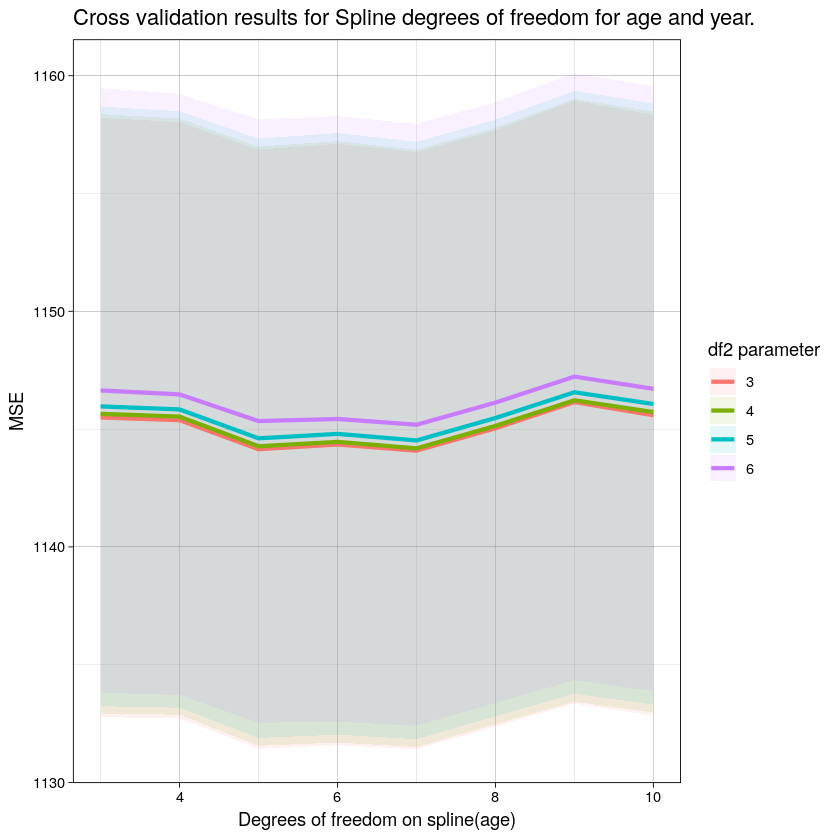

In [12]:
ggplot(spline.summary, aes(df1, Mean.Error)) +
  geom_ribbon(aes(ymin=Lower, ymax=Upper, group = factor(df2),
  fill = factor(df2)), alpha = 0.1) +
  geom_line(aes(y=Mean.Error, color = factor(df2)), lwd=1.2) +
  labs(x="Degrees of freedom on spline(age)",
  y="MSE",
  title = "Cross validation results for Spline degrees of freedom for age and year.")+
  theme(legend.position = 'bottom') +
  scale_fill_discrete(name="df2 parameter") +
  scale_color_discrete(name="df2 parameter") + theme_linedraw()

In [19]:
best_errors <- spline.summary %>% 
  group_by(df1, df2) %>% 
  summarize(best_error = min(Mean.Error))
best_errors[which.min(best_errors$best_error),]

df1,df2,best_error
<int>,<int>,<dbl>
7,3,1144.085


### 8. Fit some of the non-linear models investigated in this chapter to the `Auto` data set. Is there evidence for non-linear relationships in this data set? Create some informative plots to justify your answer.

In [2]:
glimpse(Auto)
range(Auto$year)

Observations: 392
Variables: 9
$ mpg          <dbl> 18, 15, 18, 16, 17, 15, 14, 14, 14, 15, 15, 14, 15, 14, …
$ cylinders    <dbl> 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 4, 6, 6, 6, 4,…
$ displacement <dbl> 307, 350, 318, 304, 302, 429, 454, 440, 455, 390, 383, 3…
$ horsepower   <dbl> 130, 165, 150, 150, 140, 198, 220, 215, 225, 190, 170, 1…
$ weight       <dbl> 3504, 3693, 3436, 3433, 3449, 4341, 4354, 4312, 4425, 38…
$ acceleration <dbl> 12.0, 11.5, 11.0, 12.0, 10.5, 10.0, 9.0, 8.5, 10.0, 8.5,…
$ year         <dbl> 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, 70, …
$ origin       <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3,…
$ name         <fct> chevrolet chevelle malibu, buick skylark 320, plymouth s…


[1] 70 82

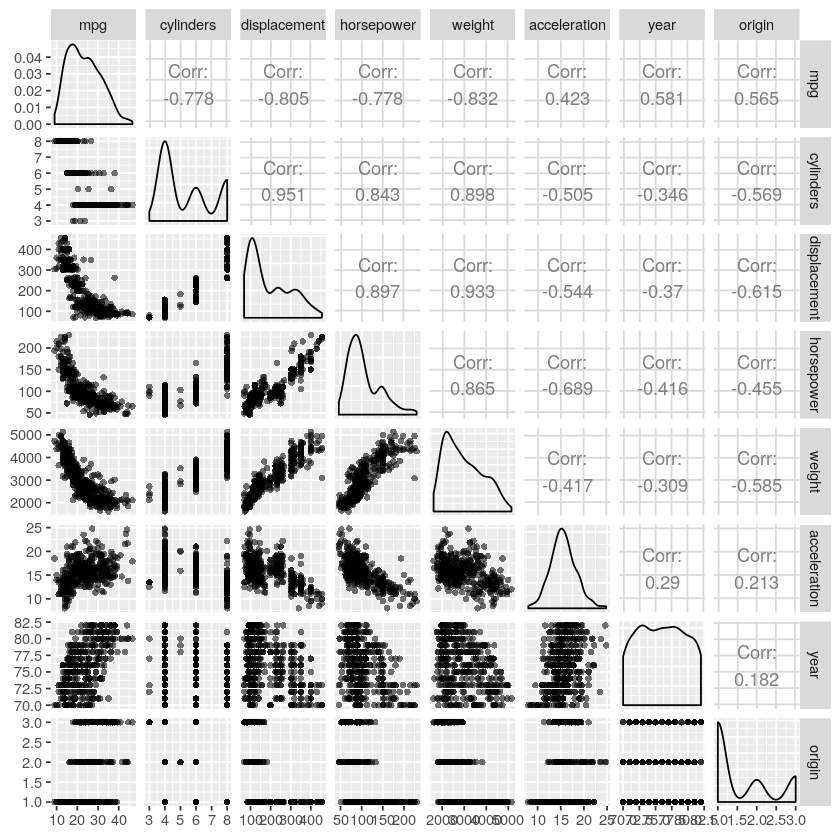

In [4]:
GGally::ggpairs(Auto, aes(alpha=0.1, pch='.'), columns=1:8)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


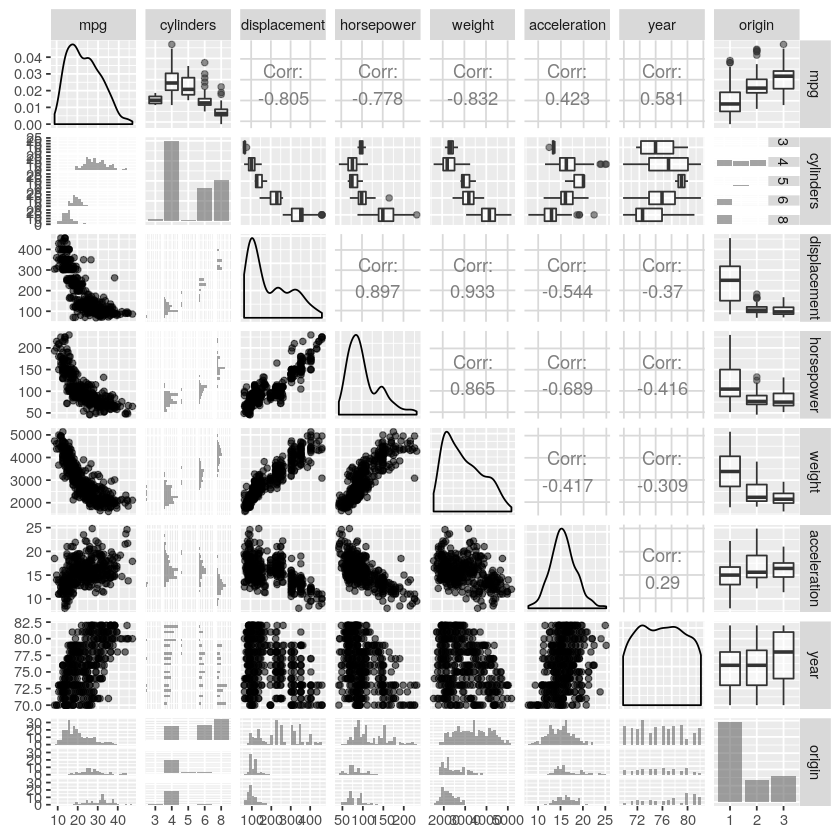

In [5]:
Auto <- Auto[1:8] %>% 
  mutate(origin = as.factor(origin),
        cylinders = as.factor(cylinders))

GGally::ggpairs(Auto, aes(alpha=0.1))

In [2]:
mdf = 8
n_fold = 10

df.v1 <- data.frame(df1=3:mdf)
df.v2 <- data.frame(df2=3:mdf)
df.v3 <- data.frame(df3=3:mdf)
df.v4 <- data.frame(df4=3:mdf)
cuts <- data.frame(cut=2:5)
fold <-  data.frame(fold=1:n_fold)

param_grid <- Reduce(merge, list(df.v1, df.v2,df.v3,df.v4,cuts,fold))

folds = sample(1:10, nrow(Auto), replace=T)

In [4]:
#get.spline.error <-function(params, foldsample = folds){
#  test<-foldsample==params[['fold']]
#  train<-!test
#  range <- range(Auto[train,'year'])
#  cuts <- seq(range[1],range[2],length=params[['cut']]+1)
#  cuts[c(1,params[['cut']]+1)]<-c(0,1000)
#  cv.model<- lm(mpg~cylinders + 
#                    bs(displacement, df=params[['df1']]) +
#                    bs(horsepower, df=params[['df2']]) + 
#                    bs(weight, df=params[['df3']]) +
#                    bs(acceleration, df=params[['df4']]) + 
#                    cut(year, breaks=cuts) + 
#                    origin,
#                data=Auto[train,])
#  predicted = predict(cv.model, Auto[test,], type='response')
#  return(mean((predicted-Auto[test,'mpg'])**2))
#}
#
#cl <- makeCluster(detectCores(), type = 'FORK')
#spline.cv.errors <- parApply(cl, param_grid,1,get.spline.error)
#stopCluster(cl)

### Jupyter notebook crashes. Ran in RStudio
### saved with:
# save(spline.cv.errors, file='Auto_spline_cv_errors.RData')
load('Auto_spline_cv_errors.RData')

In [5]:
spline.summary <- param_grid %>%
  mutate(CV.Error = spline.cv.errors) %>%
  group_by(df1, df2, df3, df4, cut) %>%
  mutate(Mean.Error = mean(CV.Error),
  Error.Stdev = sd(CV.Error),
  Mean.Error.Stdev = Error.Stdev/sqrt(length(CV.Error)),
  Lower = Mean.Error-2*Mean.Error.Stdev,
  Upper = Mean.Error+2*Mean.Error.Stdev) %>%
  ungroup()

best_errors <- spline.summary %>% 
  group_by(df1, df2, df3, df4, cut) %>%
  summarize(best_error = min(Mean.Error))
best_errors[which.min(best_errors$best_error),]

df1,df2,df3,df4,cut,best_error
<int>,<int>,<int>,<int>,<int>,<dbl>
4,3,3,3,4,7.513813


### 9. This question uses the variables dis (the weighted mean of distances to five Boston employment centers) and `nox` (nitrogen oxides concentration in parts per 10 million) from the `Boston` data. We will treat `dis` as the predictor and `nox` as the response.

#### (a) Use the `poly()` function to fit a cubic polynomial regression to predict `nox` using `dis`. Report the regression output, and plot the resulting data and polynomial fits.

In [2]:
poly_model <- lm(nox~poly(dis, 3, raw=T), data=Boston)
summary(poly_model)


Call:
lm(formula = nox ~ poly(dis, 3, raw = T), data = Boston)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.121130 -0.040619 -0.009738  0.023385  0.194904 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.9341281  0.0207076  45.110  < 2e-16 ***
poly(dis, 3, raw = T)1 -0.1820817  0.0146973 -12.389  < 2e-16 ***
poly(dis, 3, raw = T)2  0.0219277  0.0029329   7.476 3.43e-13 ***
poly(dis, 3, raw = T)3 -0.0008850  0.0001727  -5.124 4.27e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06207 on 502 degrees of freedom
Multiple R-squared:  0.7148,	Adjusted R-squared:  0.7131 
F-statistic: 419.3 on 3 and 502 DF,  p-value: < 2.2e-16


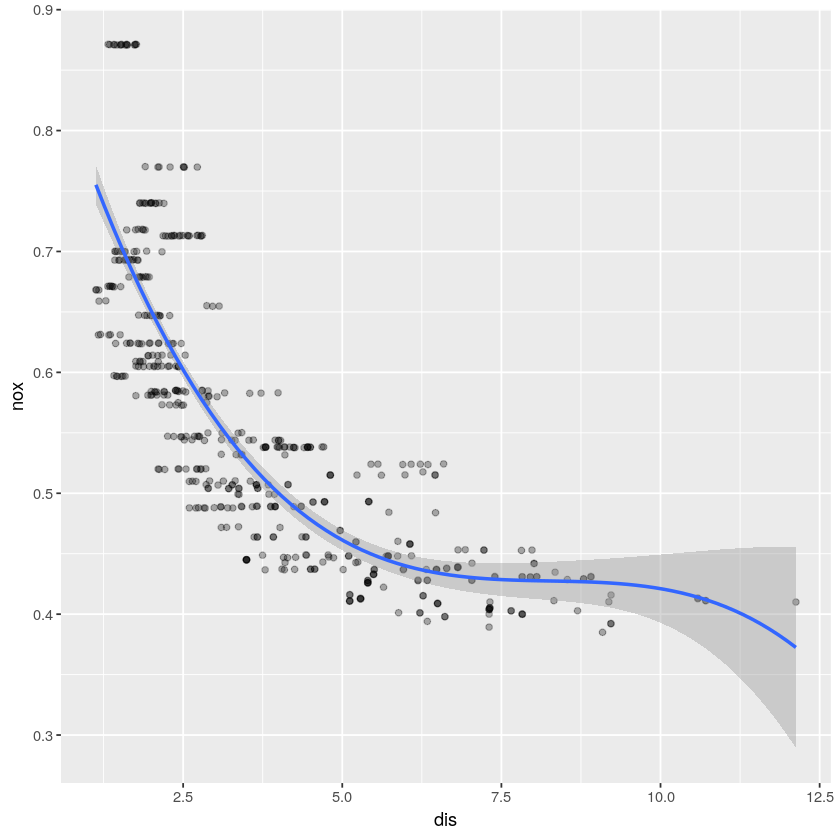

In [3]:
ggplot(Boston, aes(x=dis, y=nox))+
  geom_jitter(alpha=0.3)+
  geom_smooth(method='lm', formula = (y~poly(x, 3, raw=T)))

#### (b) Plot the polynomial fits for a range of different polynomial degrees (say, from 1 to 10), and report the associated residual sum of squares.

In [4]:
miniBoston <- Boston[,c('nox','dis')]
for (i in 1:10) {
    poly_model <- lm(nox~poly(dis,i,raw=T), data=Boston)
    cat(paste('\nPolynomial of degree', i,
              'Residual Sum of Squares:',
              round(sum(poly_model$residuals**2),3)))
    aux <- data.frame(poly_model$fitted)
    names(aux) <- paste0('degree_',i)
    miniBoston <- cbind(miniBoston, aux)
}


Polynomial of degree 1 Residual Sum of Squares: 2.769
Polynomial of degree 2 Residual Sum of Squares: 2.035
Polynomial of degree 3 Residual Sum of Squares: 1.934
Polynomial of degree 4 Residual Sum of Squares: 1.933
Polynomial of degree 5 Residual Sum of Squares: 1.915
Polynomial of degree 6 Residual Sum of Squares: 1.878
Polynomial of degree 7 Residual Sum of Squares: 1.849
Polynomial of degree 8 Residual Sum of Squares: 1.836
Polynomial of degree 9 Residual Sum of Squares: 1.833
Polynomial of degree 10 Residual Sum of Squares: 1.832

In [5]:
miniBoston_plot <- miniBoston %>% 
  gather(key='polynomial', value='fitted', degree_1:degree_10)

str(miniBoston_plot)

'data.frame':	5060 obs. of  4 variables:
 $ nox       : num  0.538 0.469 0.469 0.458 0.458 0.458 0.524 0.524 0.524 0.524 ...
 $ dis       : num  4.09 4.97 4.97 6.06 6.06 ...
 $ polynomial: chr  "degree_1" "degree_1" "degree_1" "degree_1" ...
 $ fitted    : num  0.542 0.505 0.505 0.459 0.459 ...


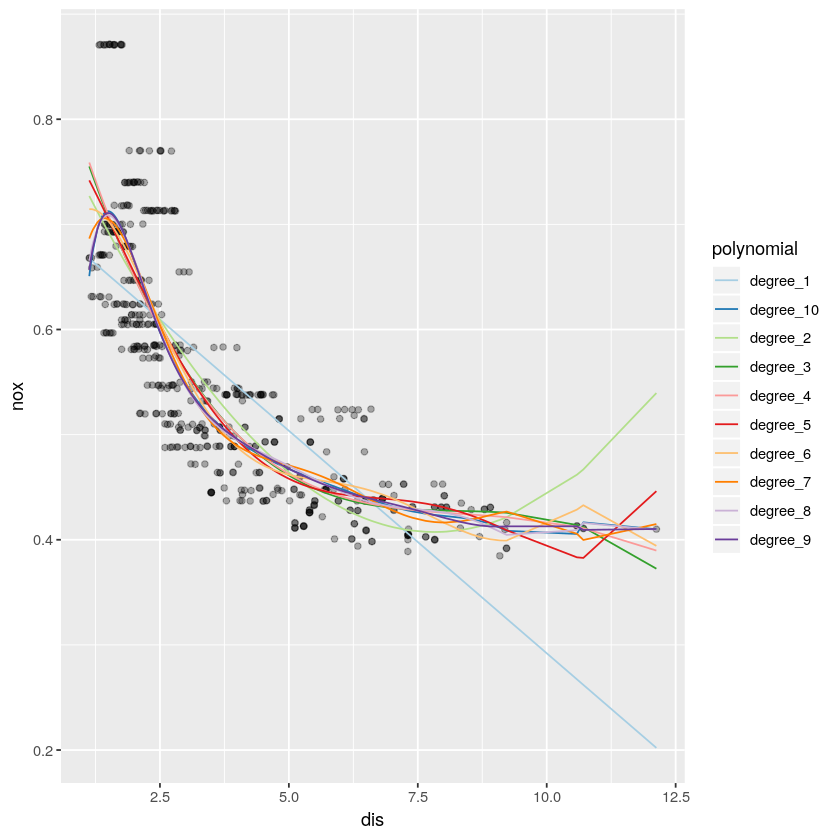

In [6]:
ggplot(Boston, aes(x=dis, y=nox)) +
  geom_jitter(alpha=0.3) +
  geom_line(data=miniBoston_plot, aes(y=fitted, x=dis, color=polynomial)) +
  scale_color_brewer(palette = 'Paired')

#### (c) Perform cross-validation or another approach to select the optimal degree for the polynomial, and explain your results.

In [7]:
Boston_poly_for_CV <- function(train, m){
  # predicts model for each polynomial of degree up to m on test sample, returns mse
  lm.pred <- sapply(1:m, function(p) {
    predict(lm(nox~poly(dis, p, raw=T), data=Boston, subset = train), 
            Boston[!train,], type='response')})
  error <- apply(lm.pred, 2, function(pred) mean((Boston[!train,'nox']-pred)**2))
  return(error)
}

Boston_CV <- function(k, rounds, m, model_for_cv, seed=NULL){
  if (!is.null(seed)) set.seed(seed)
  folds<-replicate(rounds,sample(rep(1:k, length=nrow(Boston)))) 
  cv.samples <- sapply(1:k, function(i) i==folds, simplify = "array")
  cl <- makeCluster(detectCores(), type = 'FORK')
  errors <- parApply(cl, cv.samples, -1, model_for_cv, m)
  stopCluster(cl)
  return(errors)
}

In [8]:
# Boston_poly_CV_errors <- Boston_CV(10, 100, 10, Boston_poly_for_CV, seed=125357)
load('Boston_poly_CV_errors.RData')

Warning message in self$trans$transform(x):
“NaNs produced”Warning message:
“Transformation introduced infinite values in continuous y-axis”

Degree       Error.Mean Error.Mean.Stdev            Lower 
    2.000000e+00     4.402406e-03     1.663281e-05     4.369140e-03 
           Upper 
    4.435672e-03

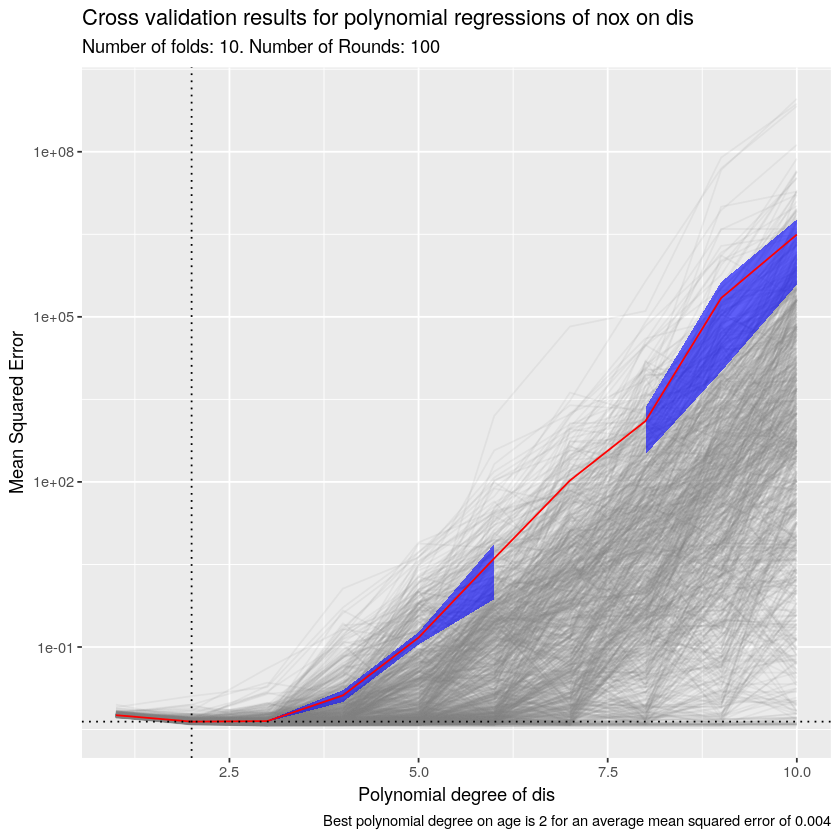

In [21]:
results <- lmcvplots(Boston_poly_CV_errors)

results$plot +
  labs(x='Polynomial degree of dis',
       title='Cross validation results for polynomial regressions of nox on dis') +
  scale_y_log10()

results$table

#### (d) Use the `bs()` function to fit a regression spline to predict `nox` using `dis`. Report the output for the fit using four degrees of freedom. How did you choose the knots? Plot the resulting fit.

In [22]:
Boston_spline <- lm(nox~bs(dis, 4), data=Boston)
summary(Boston_spline)


Call:
lm(formula = nox ~ bs(dis, 4), data = Boston)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.124622 -0.039259 -0.008514  0.020850  0.193891 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.73447    0.01460  50.306  < 2e-16 ***
bs(dis, 4)1 -0.05810    0.02186  -2.658  0.00812 ** 
bs(dis, 4)2 -0.46356    0.02366 -19.596  < 2e-16 ***
bs(dis, 4)3 -0.19979    0.04311  -4.634 4.58e-06 ***
bs(dis, 4)4 -0.38881    0.04551  -8.544  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06195 on 501 degrees of freedom
Multiple R-squared:  0.7164,	Adjusted R-squared:  0.7142 
F-statistic: 316.5 on 4 and 501 DF,  p-value: < 2.2e-16


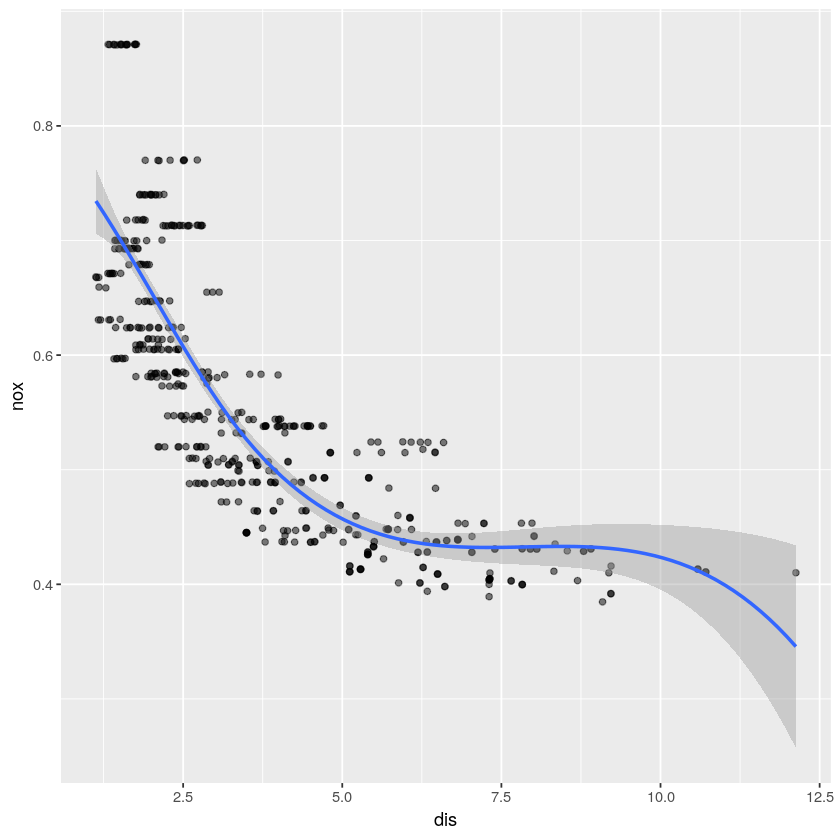

In [24]:
ggplot(Boston, aes(dis, nox)) + 
  geom_jitter(alpha=0.5) +
  geom_smooth(method='lm', formula=(y~bs(x,4)))

#### (e) Now fit a regression spline for a range of degrees of freedom, and plot the resulting fits and report the resulting RSS. Describe the results obtained.

In [25]:
miniBostonspline <- Boston[,c('nox','dis')]
for (i in 3:10) {
    spline_model <- lm(nox~bs(dis,i), data=Boston)
    cat(paste('\nSpline degrees of freedom', i,
              'Residual Sum of Squares:',
              round(sum(spline_model$residuals**2),3)))
    aux <- data.frame(spline_model$fitted)
    names(aux) <- paste0('DF_',i)
    miniBostonspline <- cbind(miniBostonspline, aux)
}


Spline degrees of freedom 3 Residual Sum of Squares: 1.934
Spline degrees of freedom 4 Residual Sum of Squares: 1.923
Spline degrees of freedom 5 Residual Sum of Squares: 1.84
Spline degrees of freedom 6 Residual Sum of Squares: 1.834
Spline degrees of freedom 7 Residual Sum of Squares: 1.83
Spline degrees of freedom 8 Residual Sum of Squares: 1.817
Spline degrees of freedom 9 Residual Sum of Squares: 1.826
Spline degrees of freedom 10 Residual Sum of Squares: 1.793

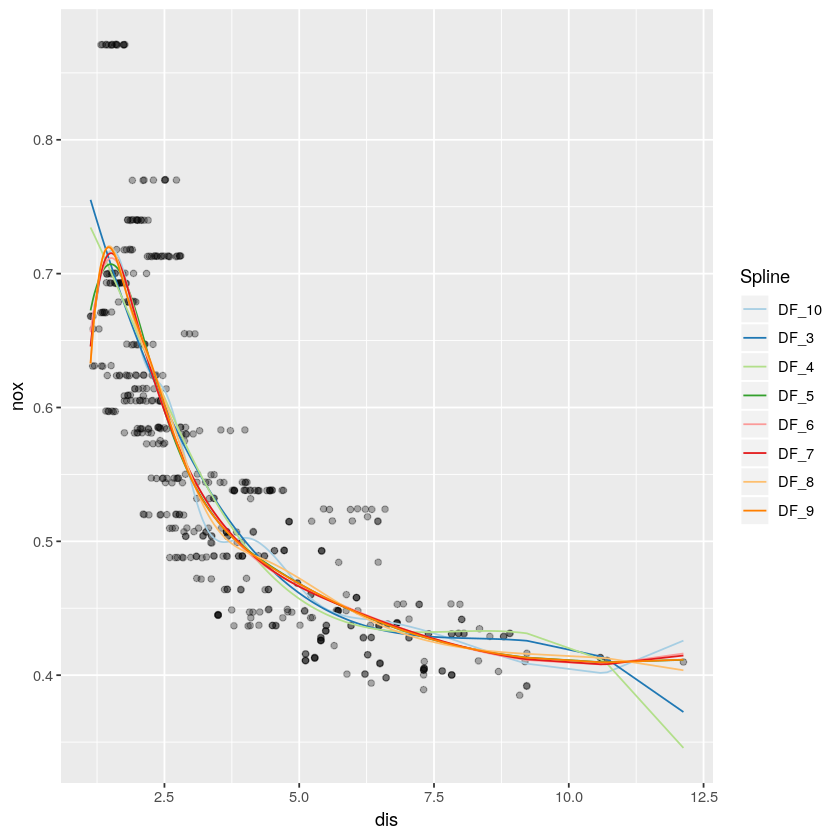

In [26]:
miniBostonspline_plot <- miniBostonspline %>% 
  gather(key='Spline', value='fitted', DF_3:DF_10)

ggplot(Boston, aes(x=dis, y=nox)) +
  geom_jitter(alpha=0.3) +
  geom_line(data=miniBostonspline_plot, aes(y=fitted, x=dis, color=Spline)) +
  scale_color_brewer(palette = 'Paired')

#### (f) Perform cross-validation or another approach in order to select the best degrees of freedom for a regression spline on this data. Describe your results.

In [27]:
Boston_spline_for_CV <- function(train, m){
  # predicts model for each polynomial of degree up to m on test sample, returns mse
  lm.pred <- sapply(3:m, function(p) {
    predict(lm(nox~bs(dis, p), data=Boston, subset = train), 
            Boston[!train,], type='response')})
  error <- apply(lm.pred, 2, function(pred) mean((Boston[!train,'nox']-pred)**2))
  return(error)
}

In [30]:
Boston_spline_CV_errors <- Boston_CV(10, 100, 10, Boston_spline_for_CV, seed=125357)

Warning message in self$trans$transform(x):
“NaNs produced”Warning message:
“Transformation introduced infinite values in continuous y-axis”

Degree       Error.Mean Error.Mean.Stdev            Lower 
    1.000000e+00     4.500668e-03     5.565836e-05     4.389351e-03 
           Upper 
    4.611985e-03

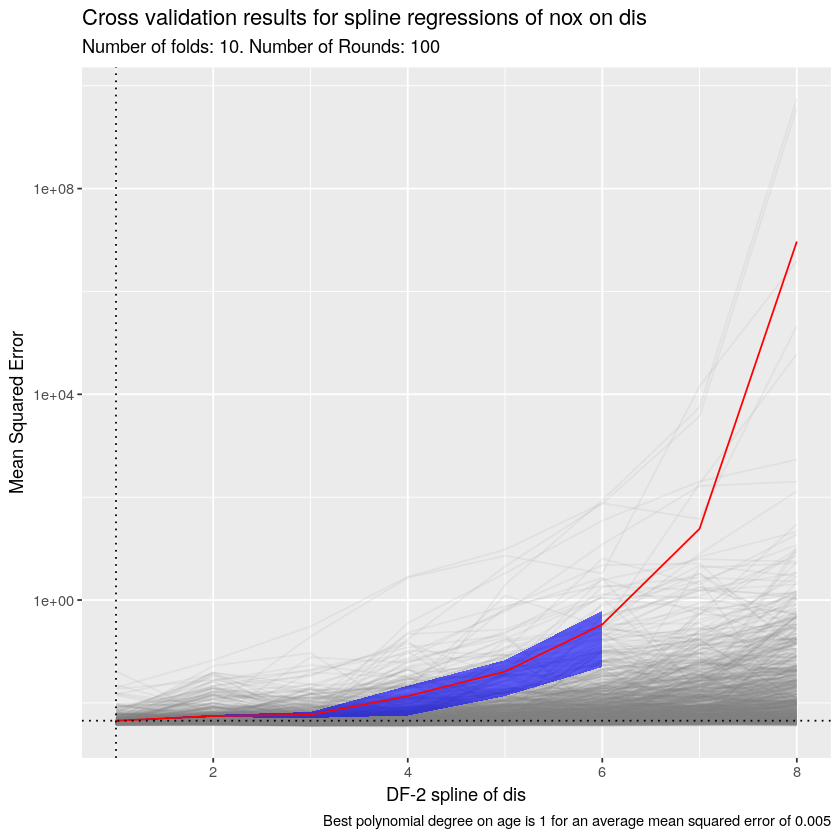

In [32]:
results2 <- lmcvplots(Boston_spline_CV_errors)

results2$plot +
  labs(x='DF-2 spline of dis',
       title='Cross validation results for spline regressions of nox on dis') +
  scale_y_log10()

results2$table

### 10. This question relates to the `College` data set.

#### (a) Split the data into a training set and a test set. Using out-of-state tuition as the response and the other variables as the predictors, perform forward stepwise selection on the training set in order to identify a satisfactory model that uses just a subset of the predictors.

In [33]:
glimpse(College)

Observations: 777
Variables: 18
$ Private     <fct> Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Yes, Ye…
$ Apps        <dbl> 1660, 2186, 1428, 417, 193, 587, 353, 1899, 1038, 582, 17…
$ Accept      <dbl> 1232, 1924, 1097, 349, 146, 479, 340, 1720, 839, 498, 142…
$ Enroll      <dbl> 721, 512, 336, 137, 55, 158, 103, 489, 227, 172, 472, 484…
$ Top10perc   <dbl> 23, 16, 22, 60, 16, 38, 17, 37, 30, 21, 37, 44, 38, 44, 2…
$ Top25perc   <dbl> 52, 29, 50, 89, 44, 62, 45, 68, 63, 44, 75, 77, 64, 73, 4…
$ F.Undergrad <dbl> 2885, 2683, 1036, 510, 249, 678, 416, 1594, 973, 799, 183…
$ P.Undergrad <dbl> 537, 1227, 99, 63, 869, 41, 230, 32, 306, 78, 110, 44, 63…
$ Outstate    <dbl> 7440, 12280, 11250, 12960, 7560, 13500, 13290, 13868, 155…
$ Room.Board  <dbl> 3300, 6450, 3750, 5450, 4120, 3335, 5720, 4826, 4400, 338…
$ Books       <dbl> 450, 750, 400, 450, 800, 500, 500, 450, 300, 660, 500, 40…
$ Personal    <dbl> 2200, 1500, 1165, 875, 1500, 675, 1500, 850, 500, 1800, 6…
$ PhD         <dbl> 

In [51]:
set.seed(98471504)
train <- sample(1:nrow(College), round(nrow(College)*0.8))
step_model <- step(lm(Outstate~1, data=College, subset=train), 
                   scope=list(lower=Oustate~1, upper=Outstate~
                             Private + Apps + Accept + Enroll + Top10perc + Top25perc + 
    F.Undergrad + P.Undergrad + Room.Board + Books + Personal + 
    PhD + Terminal + S.F.Ratio + perc.alumni + Expend + Grad.Rate),
                   direction = "forward", k=log(length(train)),
                  trace=0)

summary(step_model)


Call:
lm(formula = Outstate ~ Expend + Private + Room.Board + perc.alumni + 
    PhD + Grad.Rate, data = College, subset = train)

Residuals:
   Min     1Q Median     3Q    Max 
 -7649  -1311    -73   1204  10566 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -3.429e+03  4.928e+02  -6.959 8.81e-12 ***
Expend       2.144e-01  2.000e-02  10.724  < 2e-16 ***
PrivateYes   2.748e+03  2.339e+02  11.747  < 2e-16 ***
Room.Board   9.695e-01  9.445e-02  10.264  < 2e-16 ***
perc.alumni  4.406e+01  8.463e+00   5.206 2.64e-07 ***
PhD          3.661e+01  6.240e+00   5.867 7.24e-09 ***
Grad.Rate    2.902e+01  6.015e+00   4.824 1.77e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2084 on 615 degrees of freedom
Multiple R-squared:  0.7309,	Adjusted R-squared:  0.7283 
F-statistic: 278.4 on 6 and 615 DF,  p-value: < 2.2e-16


#### (b) Fit a GAM on the training data, using out-of-state tuition as the response and the features selected in the previous step as the predictors. Plot the results, and explain your findings.

In [64]:
require(gam)
vars <- labels(terms(step_model))

College.gam1 <- gam(Outstate ~ s(Expend,5) + Private + s(Room.Board,5) +
                   s(PhD,5) + s(Grad.Rate,5), data = College, subset=train)

summary(College.gam1)

Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”


Call: gam(formula = Outstate ~ s(Expend, 5) + Private + s(Room.Board, 
    5) + s(PhD, 5) + s(Grad.Rate, 5), data = College, subset = train)
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-7467.12 -1062.42   -33.82  1300.58  7822.27 

(Dispersion Parameter for gaussian family taken to be 3730592)

    Null Deviance: 9928124910 on 621 degrees of freedom
Residual Deviance: 2238354931 on 600 degrees of freedom
AIC: 11200.91 

Number of Local Scoring Iterations: 2 

Anova for Parametric Effects
                  Df     Sum Sq    Mean Sq  F value    Pr(>F)    
s(Expend, 5)       1 4351004511 4351004511 1166.304 < 2.2e-16 ***
Private            1 1258705947 1258705947  337.401 < 2.2e-16 ***
s(Room.Board, 5)   1  472756568  472756568  126.724 < 2.2e-16 ***
s(PhD, 5)          1  115025141  115025141   30.833 4.228e-08 ***
s(Grad.Rate, 5)    1  183773333  183773333   49.261 6.079e-12 ***
Residuals        600 2238354931    3730592                       
---
Signif. codes:  0 

In [66]:
College.gam2 <- gam(Outstate ~ s(Expend,5) + Private + s(Room.Board,5) +
                   PhD + s(Grad.Rate,5), data = College, subset=train)

summary(College.gam2)

Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”


Call: gam(formula = Outstate ~ s(Expend, 5) + Private + s(Room.Board, 
    5) + PhD + s(Grad.Rate, 5), data = College, subset = train)
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-7544.48 -1091.35   -24.92  1272.18  8243.72 

(Dispersion Parameter for gaussian family taken to be 3742343)

    Null Deviance: 9928124910 on 621 degrees of freedom
Residual Deviance: 2260375294 on 604 degrees of freedom
AIC: 11199 

Number of Local Scoring Iterations: 2 

Anova for Parametric Effects
                  Df     Sum Sq    Mean Sq  F value    Pr(>F)    
s(Expend, 5)       1 4379376602 4379376602 1170.223 < 2.2e-16 ***
Private            1 1241061225 1241061225  331.627 < 2.2e-16 ***
s(Room.Board, 5)   1  468653885  468653885  125.230 < 2.2e-16 ***
PhD                1  109028641  109028641   29.134 9.717e-08 ***
s(Grad.Rate, 5)    1  181849018  181849018   48.592 8.281e-12 ***
Residuals        604 2260375294    3742343                       
---
Signif. codes:  0 ‘***’ 0.0

In [68]:
College.gam3 <- gam(Outstate ~ s(Expend,5) + Private + s(Room.Board,5) +
                   PhD + Grad.Rate, data = College, subset=train)

summary(College.gam3)

Warning message in model.matrix.default(mt, mf, contrasts):
“non-list contrasts argument ignored”


Call: gam(formula = Outstate ~ s(Expend, 5) + Private + s(Room.Board, 
    5) + PhD + Grad.Rate, data = College, subset = train)
Deviance Residuals:
     Min       1Q   Median       3Q      Max 
-7591.72 -1101.77   -22.18  1251.23  8177.06 

(Dispersion Parameter for gaussian family taken to be 3762743)

    Null Deviance: 9928124910 on 621 degrees of freedom
Residual Deviance: 2287746749 on 607.9997 degrees of freedom
AIC: 11198.49 

Number of Local Scoring Iterations: 2 

Anova for Parametric Effects
                  Df     Sum Sq    Mean Sq  F value    Pr(>F)    
s(Expend, 5)       1 4395037323 4395037323 1168.041 < 2.2e-16 ***
Private            1 1253385208 1253385208  333.104 < 2.2e-16 ***
s(Room.Board, 5)   1  462913101  462913101  123.025 < 2.2e-16 ***
PhD                1  116583900  116583900   30.984 3.906e-08 ***
Grad.Rate          1  176797594  176797594   46.986 1.759e-11 ***
Residuals        608 2287746749    3762743                       
---
Signif. codes:  0 ‘***’ 0

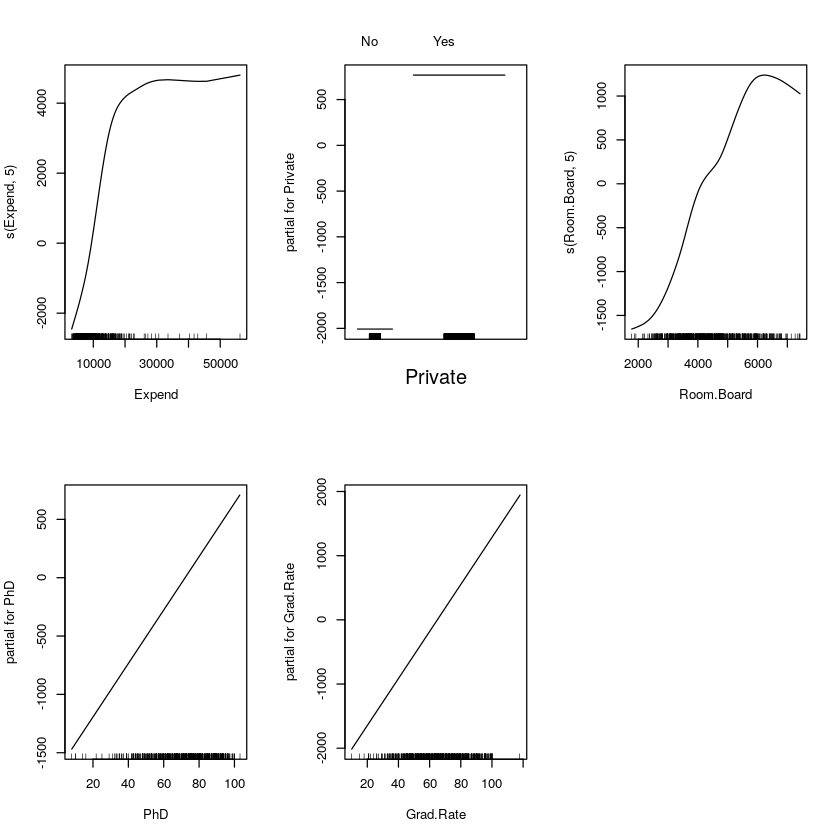

In [71]:
par(mfrow=c(2,3))
plot(College.gam3)

#### (c) Evaluate the model obtained on the test set, and explain the results obtained.

In [74]:
y_pred1 <- predict(College.gam1, newdata=College[-train,], type='response')
y_pred2 <- predict(College.gam2, newdata=College[-train,], type='response')
y_pred3 <- predict(College.gam3, newdata=College[-train,], type='response')
MSE1 <- mean((College$Outstate[-train]-y_pred1)**2)
MSE2 <- mean((College$Outstate[-train]-y_pred2)**2)
MSE3 <- mean((College$Outstate[-train]-y_pred3)**2)
print(c(MSE1, MSE2, MSE3))
print(mean(College.gam3$residuals**2))

[1] 2861641 2883057 2915187
[1] 3678049


#### (d) For which variables, if any, is there evidence of a non-linear relationship with the response?

### 11. 

In Section 7.7, it was mentioned that GAMs are generally fit using a backfitting approach. The idea behind backfitting is actually quite simple. We will now explore backfitting in the context of multiple linear regression.

Suppose that we would like to perform multiple linear regression, but we do not have software to do so. Instead, we only have software to perform simple linear regression. Therefore, we take the following iterative approach: we repeatedly hold all but one coefficient esti mate fixed at its current value, and update only that coefficient estimate using a simple linear regression. The process is continued until convergence - that is, until the coefficient estimates stop changing.

We now try this out on a toy example.

### (a) Generate a response $Y$ and two predictors $X_1$ and $X_2$ , with $n = 100$.

In [144]:
set.seed(69816387)
x1 <- runif(100)
x2 <- rnorm(100, 3, 2)
y <- 20+ 30*x1 + 40*x2 +rnorm(100)

### (b) Initialize $\hat\beta_1$ to take on a value of your choice. It does not matter what value you choose.

In [133]:
hatbeta1 <- 0

### (c) Keeping $\hat\beta_1$ fixed, fit the model
$$
Y - \hat\beta_1 X_1 = \beta_0 + \beta_2 X_2 + \varepsilon.
$$
### You can do this as follows:
```
> a = y - beta1 * x1
> beta2 = lm (a∼x2)$coef[2]
```

In [134]:
z <- y - hatbeta1*x1
hatbeta2 <- coef(lm(z~x2))[2]

### (d) Keeping $\hat\beta_2$ fixed, fit the model
$$
Y - \hat\beta_2 X_2 = \beta_0 + \beta_1 X_1 + \varepsilon.
$$
### You can do this as follows:
```
> a = y - beta2 * x2
> beta1 = lm(a∼x1)$coef[2]
```

In [136]:
z <- y - hatbeta2*x2
hatbeta1 <- coef(lm(z~x1))[2]

c(coef(lm(z~x1))[1], hatbeta1, hatbeta2)

(Intercept)          x1          x2 
   2.467400    2.488870    3.983096

### (e) Write a for loop to repeat (c) and (d) 1,000 times. Report the estimates of $\hat\beta_0$ , $\hat\beta_1$ , and $\hat\beta_2$ at each iteration of the for loop. Create a plot in which each of these values is displayed, with $\hat\beta_0$ , $\hat\beta_1$ , and $\hat\beta_2$ each shown in a different color.

iteraction,intercept,beta1,beta2
<int>,<dbl>,<dbl>,<dbl>
1,19.88546,29.42307,40.19239
2,20.51962,29.49477,39.96431
3,20.52117,29.49495,39.96376
4,20.52117,29.49495,39.96376
5,20.52117,29.49495,39.96376


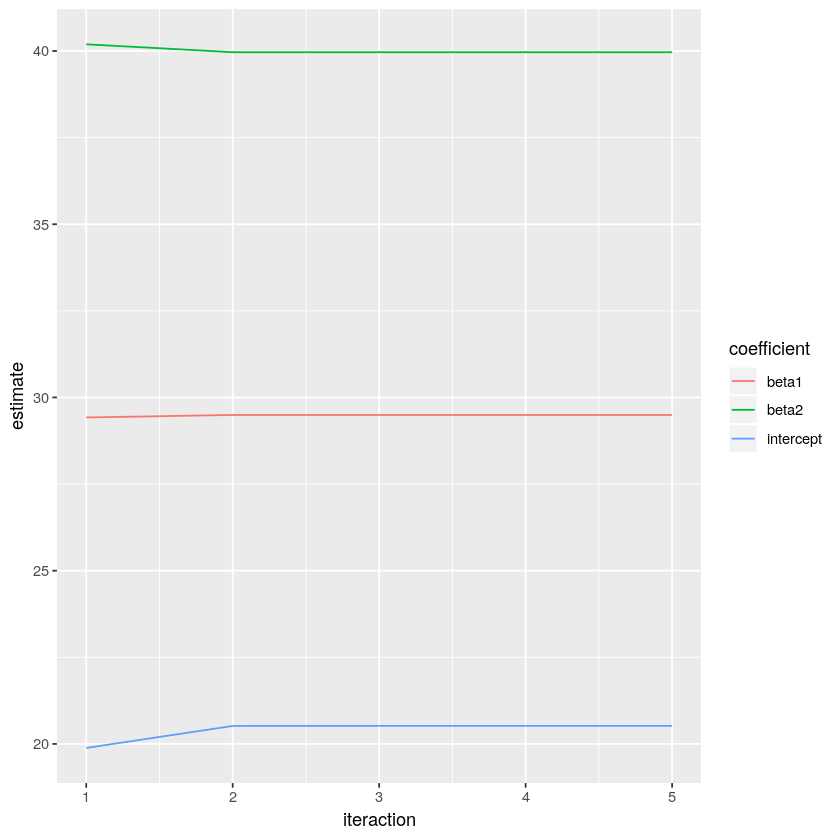

In [145]:
### 1000 is too many. results converge in 5-6 iteractions
iteractions <- 5
coefficients <- data.frame(iteraction = 1:iteractions,
                           intercept = numeric(iteractions),
                           beta1 = numeric(iteractions),
                           beta2 = numeric(iteractions))
hatcoef <- numeric(3)

for (i in 1:iteractions){
    z <- y - hatcoef[2]*x1
    hatcoef[3] <- coef(lm(z~x2))[2]
    z <- y - hatcoef[3]*x2
    hatcoef[1:2] <- coef(lm(z~x1))
    coefficients[i,2:4]<-hatcoef
}

g <- coefficients %>% 
   gather(key = 'coefficient', value = 'estimate', intercept:beta2) %>% 
   ggplot(aes(iteraction, estimate, color=coefficient)) +
   geom_line()

g

head(coefficients)

### (f) Compare your answer in (e) to the results of simply performing multiple linear regression to predict Y using X 1 and X 2 . Use the abline() function to overlay those multiple linear regression coefficient estimates on the plot obtained in (e).

(Intercept)          x1          x2 
   20.52117    29.49495    39.96376

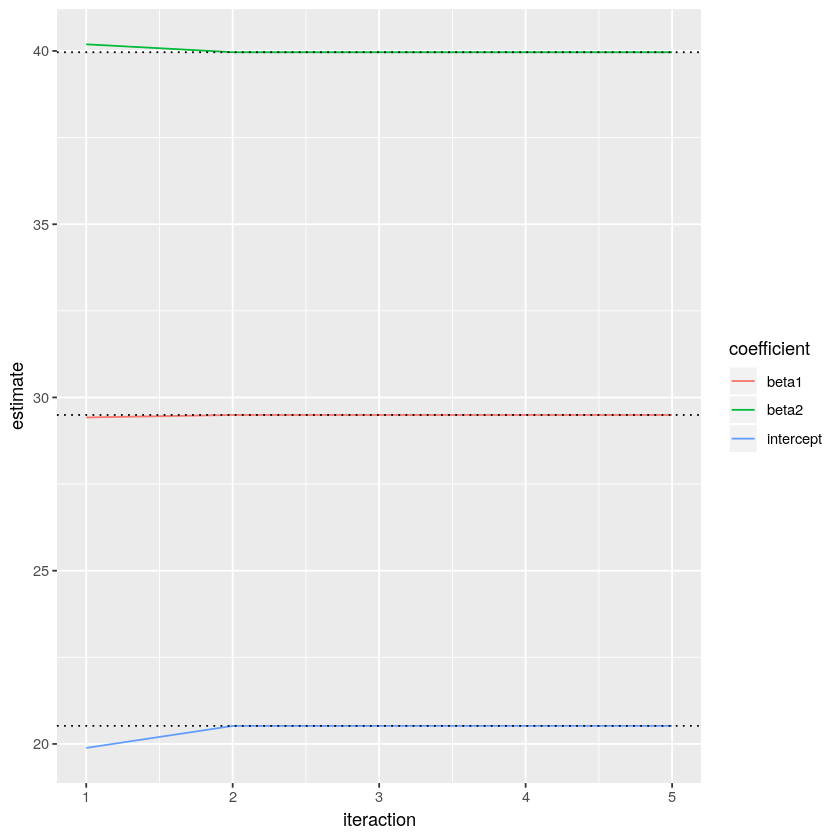

In [152]:
mlr <- lm(y~x1+x2)
mlr_coef <- coef(mlr)
mlr_coef

g + geom_hline(lty=3, yintercept=mlr_coef)

### (g) On this data set, how many backfitting iterations were required in order to obtain a “good” approximation to the multiple regression coefficient estimates?

2 is good, 3 is exact

### 12. This problem is a continuation of the previous exercise. In a toy example with $p = 100$, show that one can approximate the multiple linear regression coefficient estimates by repeatedly performing simple linear regression in a backfitting procedure. How many backfitting iterations are required in order to obtain a “good” approximation to the multiple regression coefficient estimates? Create a plot to justify your answer.

In [193]:
set.seed(69816387)
p=100
X <- matrix(runif(2*p**2, 2, 3), ncol=p)
betas <- sample(1:20, p, replace=T)
y <- 5 + X%*%betas + rnorm(2*p)

mlr_coefficients <- coef(lm(y~X))

In [194]:
hatcoef <- numeric(p+1)
iteractions <- 200

coefficients <- data.frame(cbind(1:iteractions,
                                 array(numeric((p+1)*iteractions),c(iteractions, p+1))))
names(coefficients) <- c('iteraction',names(mlr_coefficients))

head(coefficients,2)

iteraction,(Intercept),X1,X2,X3,X4,X5,X6,X7,X8,⋯,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [195]:
for (i in 1:iteractions){
    for (j in 1:p){
        z <- y - X[,-j]%*%hatcoef[-c(1,j+1)]
        hatcoef[c(1,j+1)] <- coef(lm(z~X[,j]))}
    coefficients[i,-1]<-hatcoef
}

In [196]:
head(coefficients)

iteraction,(Intercept),X1,X2,X3,X4,X5,X6,X7,X8,⋯,X91,X92,X93,X94,X95,X96,X97,X98,X99,X100
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,550.49270,5.765309,1.1179097,-9.0532661,7.836165,20.61375,11.690032,-5.97752173,11.01133,⋯,7.149892,13.38277,15.16639,8.466157,3.516018,6.539729,8.748091,4.971230,14.83177,6.500896
2,325.49229,15.346590,0.4953292,-9.9607538,14.985413,13.45966,8.815977,-5.44832444,11.12990,⋯,13.364041,14.10269,18.41765,9.398285,7.767397,8.753411,11.905813,4.437538,15.89281,10.860492
3,199.66514,11.302897,2.2242368,-4.4791248,15.016693,12.12914,8.133228,-3.94957615,10.99958,⋯,15.177916,13.82247,19.27844,9.543237,9.432719,9.830305,13.814771,4.129863,17.26238,12.486226
4,118.88936,9.895710,1.9323046,-1.5262681,14.970939,11.78283,7.710175,-1.75562549,10.52606,⋯,15.982545,13.55709,19.48698,9.669393,10.111933,10.742043,14.843736,4.075605,18.06647,13.291155
5,70.24502,9.345369,1.5461242,-0.1294562,14.760203,11.76125,7.585407,-0.63601395,10.27320,⋯,16.380331,13.40384,19.62991,9.722254,10.609934,11.424219,15.365007,4.090126,18.50183,13.724351
6,41.82148,9.025420,1.3508502,0.5861451,14.467390,11.73790,7.611197,-0.05029273,10.22243,⋯,16.612951,13.30230,19.74735,9.715230,11.016943,11.889609,15.620456,4.119781,18.75541,13.937856


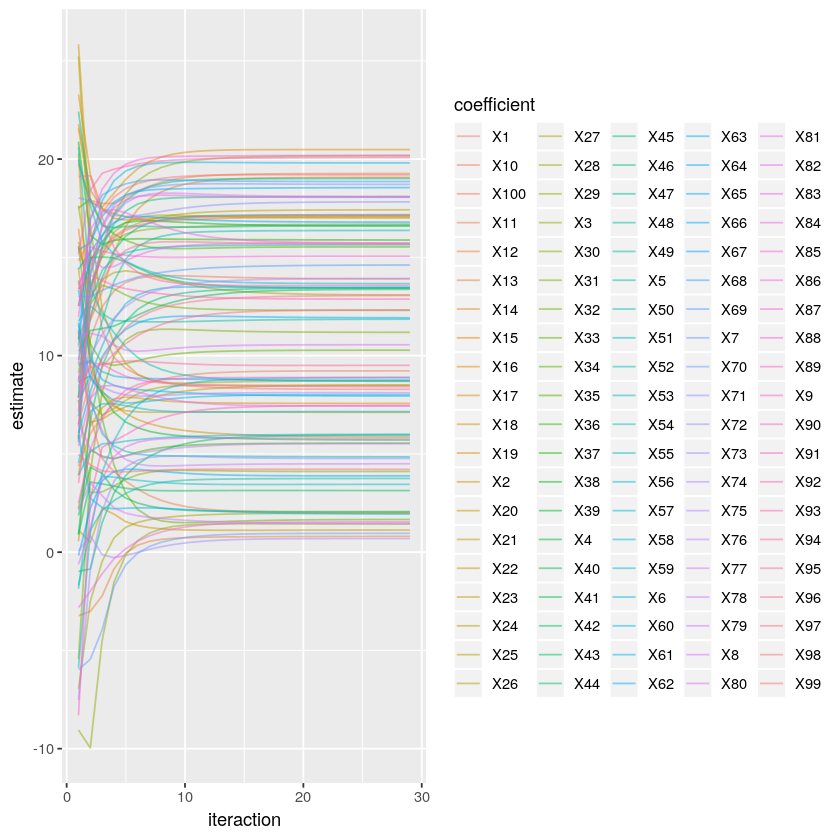

In [199]:
g <- coefficients %>% 
   filter(iteraction < 30) %>% 
   gather(key = 'coefficient', value = 'estimate', -iteraction) %>% 
   filter(coefficient!='(Intercept)') %>% 
   ggplot(aes(iteraction, estimate, color=coefficient)) +
   geom_line(alpha=0.5)
g

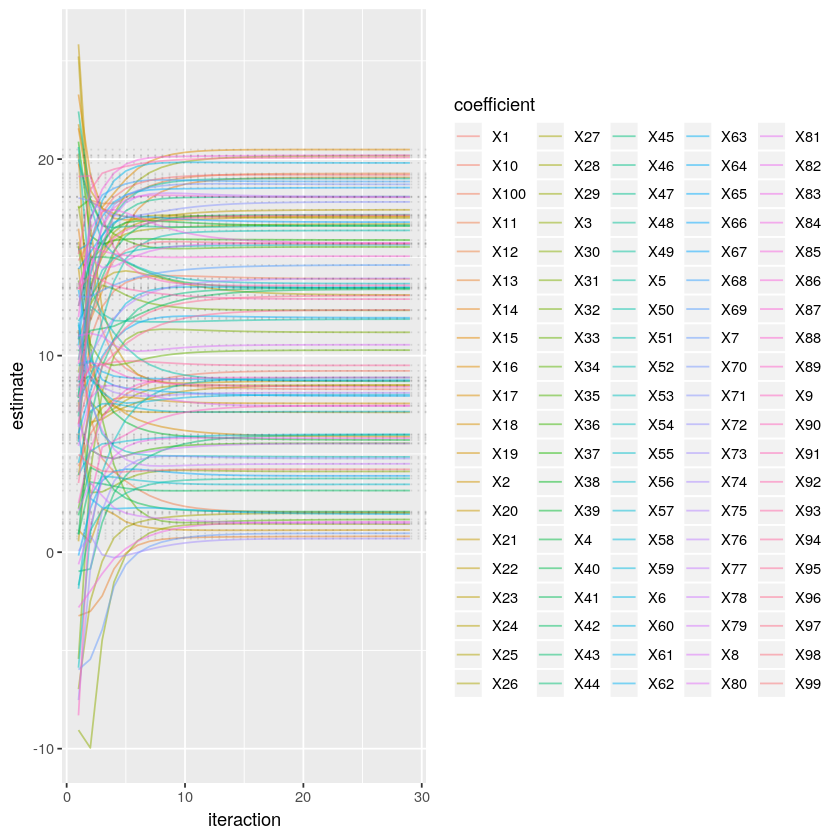

In [201]:
g + geom_hline(lty=3, yintercept=mlr_coefficients[-1], alpha=0.1)

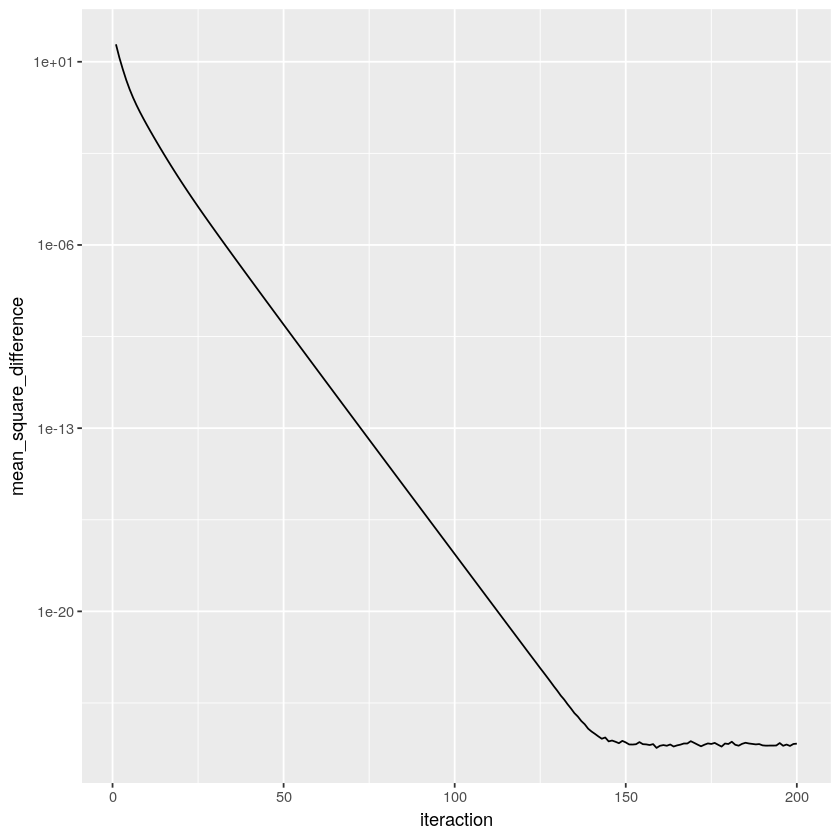

In [212]:
ggplot(
    data.frame(t(apply(coefficients, 1, function(x){
        c(x[1], 
          mean_square_difference = mean((x[-c(1:2)]-mlr_coefficients[-1])**2))
    }))), 
    aes(iteraction, mean_square_difference)) +
    geom_line() +
    scale_y_log10()

Diferrences stabilize at around 150 iteractions, or $1.5p$.